# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [1]:
import h2o
import os
import numpy as np
import math
import shap
import pandas as pd

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch 

# init h2o
h2o.init(max_mem_size='12G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,4 days 4 hours 27 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,"28 days, 1 hour and 36 minutes"
H2O cluster name:,H2O_from_python_ngill_vo2rw9
H2O cluster total nodes:,1
H2O cluster free memory:,10.20 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [2]:
train_path = os.sep.join(['..', 'data', 'output', 'hmda_train.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'hmda_test.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
# Ensure debt_to_income_ratio is categorical
train['debt_to_income_ratio'] = train['debt_to_income_ratio'].asfactor()
test['debt_to_income_ratio'] = test['debt_to_income_ratio'].asfactor()

In [4]:
train.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold
2.5493e+06,175000,97,1,0,185000,36,0,47,1,1,nan,nan,nan,nan,nan,nan,nan,1,0,1,0,1
4.00076e+06,265000,95,1,0,285000,100,0,,1,1,0,0,1,0,0,0,1,nan,nan,1,0,5
1.54693e+06,115000,97,0,120,125000,59,0,39,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,5
5.45314e+06,275000,57.9,1,0,475000,100,0,,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3
4.94313e+06,155000,99,1,0,155000,42,0,46,1,1,0,0,1,0,0,1,0,nan,nan,0,1,4
1.23729e+06,215000,95,1,0,225000,81,0,42,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3
682016,195000,95,1,0,205000,92,0,49,1,1,0,0,1,0,0,0,1,0,1,nan,nan,1
19740,125000,100,1,0,125000,38,0,43,1,1,0,0,1,0,0,0,1,1,0,nan,nan,2
5.36388e+06,355000,90,1,0,395000,95,0,38,1,1,0,0,1,0,0,0,1,nan,nan,0,1,5
1.94229e+06,595000,80,1,0,745000,371,0,,1,0,0,0,1,0,0,0,1,nan,nan,0,1,4


In [5]:
train.summary()

,C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold
type,int,int,real,int,int,int,int,int,enum,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,49.0,5000.0,1.0,0.0,0.0,5000.0,-130.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
mean,3319386.4112125635,291981.00263194024,86.64662923818423,0.9436378151155683,5.35342838254188,358807.76858885604,152.333788621537,0.09670196709451284,,0.9603275580336539,0.928027042871933,0.0787575295739894,0.07867769794614994,0.8355541040714131,0.004434284055446694,0.0025763843530009433,0.12107167983057363,0.8789283201694263,0.6126165686353814,0.3873834313646186,0.21633871324342252,0.7836612867565775,3.0030373336327
maxs,6504996.0,12005000.0,900.0,1.0,425.0,13605000.0,882000.0,1.0,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0
sigma,1952820.8522752034,227416.2209992358,15.01109708563018,0.2306205123360138,24.864561487883368,324310.1569850146,2886.174831533794,0.295552434347859,,0.1951890799460008,0.25844393424533546,0.26936092454879995,0.2692360374620666,0.3706810494787445,0.06644285679708556,0.05069285202604093,0.3262117410182472,0.3262117410182472,0.48715526363003847,0.48715526363003847,0.41175035739904686,0.41175035739904686,1.4115197617501203
zeros,0,0,0,9037,151301,0,982,144833,,6361,11540,126938,126949,22659,137179,137435,121184,16693,33523,53014,63801,17613,0
missing,0,0,0,0,0,0,0,0,74997,0,0,22548,22548,22548,22548,22548,22461,22461,73801,73801,78924,78924,0
0,2549300.0,175000.0,97.0,1.0,0.0,185000.0,36.0,0.0,47,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,1.0,0.0,1.0
1,4000757.0,265000.0,95.0,1.0,0.0,285000.0,100.0,0.0,,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,1.0,0.0,5.0
2,1546928.0,115000.0,97.0,0.0,120.0,125000.0,59.0,0.0,39,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,5.0


In [6]:
test.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62
131497,185000,96.5,1,0,195000,129,0,,1,1,0,1,0,0,0,1,0,1,0,nan,nan
851117,365000,95,0,85,385000,121,0,,1,1,0,1,0,0,0,0,1,1,0,nan,nan
835616,265000,96.28,1,0,265000,106,0,49,1,1,0,0,1,0,0,0,1,nan,nan,0,1
121491,145000,56.91,1,0,255000,68,0,38,0,1,0,0,1,0,0,0,1,1,0,1,0
4.47964e+06,355000,95,1,0,375000,154,0,46,1,1,0,0,1,0,0,0,1,nan,nan,0,1
843194,365000,96.5,1,0,375000,51,1,,1,1,0,1,0,0,0,nan,nan,nan,nan,0,1
6.37726e+06,195000,96.5,1,0,205000,54,0,,1,1,0,0,1,0,0,0,1,0,1,nan,nan
5.25537e+06,135000,80,1,0,165000,81,0,48,1,1,0,0,1,0,0,1,0,0,1,nan,nan
4.59782e+06,455000,68.76,0,120,655000,82,0,41,1,1,0,1,0,0,0,0,1,1,0,nan,nan
6.13819e+06,325000,80,1,0,405000,65,0,49,1,1,0,0,1,0,0,0,1,nan,nan,1,0


In [7]:
test.summary()

,C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62
type,int,int,real,int,int,int,int,int,enum,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,4056.0,5000.0,1.0,0.0,0.0,25000.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3323235.64242852,292912.61156774743,88.56029290647881,0.9412283798093893,5.4916040542584845,360743.028591599,182.90381221320155,0.09752407846301246,,0.9601885936160557,0.9262014018455953,0.07671265111627497,0.08197782157249169,0.8342206665293996,0.004294496573227049,0.0027943642086066416,0.12101442886949366,0.8789855711305063,0.6133134578655611,0.3866865421344389,0.22066733067729083,0.7793326693227092
maxs,6504997.0,4625000.0,79474.0,1.0,360.0,9245000.0,396000.0,1.0,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,1954622.3871122967,224087.83385259155,398.9005406950038,0.23519972706038758,24.4766458606141,321800.26166856906,3600.669509692802,0.29667381367158185,,0.19551834219733183,0.2614461483363615,0.2661388804577039,0.27433496324350387,0.3718879052734942,0.06539250456663769,0.05278861339759911,0.3261488353928688,0.3261488353928688,0.487002164716498,0.487002164716498,0.4147069141947798,0.4147069141947798
zeros,0,0,0,2331,37331,0,231,35794,,1579,2927,31389,31210,5636,33851,33902,29911,4118,8301,13166,15649,4431
missing,0,0,0,0,0,0,0,0,18562,0,0,5665,5665,5665,5665,5665,5633,5633,18195,18195,19582,19582
0,131497.0,185000.0,96.5,1.0,0.0,195000.0,129.0,0.0,,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,nan,nan
1,851117.0,365000.0,95.0,0.0,85.0,385000.0,121.0,0.0,,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,nan,nan
2,835616.0,265000.0,96.28,1.0,0.0,265000.0,106.0,0.0,49,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,0.0,1.0


In [8]:
# Inputs and output
X = ['loan_amount', 'loan_to_value_ratio', 'no_intro_rate_period', 'intro_rate_period',
    'property_value', 'income', "debt_to_income_ratio", "term_360", "conforming"]
fold_column = 'cv_fold'
Y = "high_priced"

In [9]:
# Convert outcome to categorical
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

In [10]:
# Distribution of outcome in train
train[Y].table()

high_priced,Count
0,144833
1,15505


In [11]:
# Distribution of outcome in test
test[Y].table()

high_priced,Count
0,35794
1,3868


In [12]:
# Create Pandas frame for correlation purposes
train_pd_for_corr = train.as_data_frame()

In [13]:
# Get correlation
numeric_corr = pd.DataFrame(train_pd_for_corr[X + [Y]].corr()[Y]).iloc[:-1]
numeric_corr

,high_priced
loan_amount,-0.123545
loan_to_value_ratio,0.190882
no_intro_rate_period,0.018108
intro_rate_period,-0.031716
property_value,-0.137319
income,-0.007911
debt_to_income_ratio,0.031007
term_360,0.052448
conforming,0.074543


In [14]:
# Apply monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train_pd_for_corr[X + [Y]].corr()[Y].values[:-1])])
mono_constraints = dict(zip(list(numeric_corr.index.tolist()), mono_constraints))
del mono_constraints['debt_to_income_ratio']
mono_constraints

{'loan_amount': -1,
 'loan_to_value_ratio': 1,
 'no_intro_rate_period': 1,
 'intro_rate_period': -1,
 'property_value': -1,
 'income': -1,
 'term_360': 1,
 'conforming': 1}

In [15]:
# Default GBM
mgbm_default = H2OGradientBoostingEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED,
               categorical_encoding="one_hot_explicit")
mgbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [16]:
mgbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1574453305437_6858


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,15673.0,5.0,5.0,5.0,14.0,28.0,20.26




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07752043996136684
RMSE: 0.27842492697559756
LogLoss: 0.2647595398015099
Mean Per-Class Error: 0.2581603561234854
AUC: 0.7985161210467326
pr_auc: 0.27079320515609845
Gini: 0.5970322420934653

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17854260903985114: 


,,0,1,Error,Rate
0,0,116714.0,28119.0,0.1941,(28119.0/144833.0)
1,1,5908.0,9597.0,0.381,(5908.0/15505.0)
2,Total,122622.0,37716.0,0.2122,(34027.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.178543,0.360647,189.0
1,max f2,0.098258,0.516180,256.0
2,max f0point5,0.240378,0.301153,145.0
3,max accuracy,0.660467,0.903311,5.0
4,max precision,0.756203,1.000000,0.0
5,max recall,0.007380,1.000000,397.0
6,max specificity,0.756203,1.000000,0.0
7,max absolute_mcc,0.121275,0.302827,233.0
8,max min_per_class_accuracy,0.125335,0.735564,230.0
9,max mean_per_class_accuracy,0.098258,0.741840,256.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010172,0.381607,4.317753,4.317753,0.417535,0.446180,0.417535,0.446180,0.043921,0.043921,331.775347,331.775347
1,,2,0.022783,0.345399,3.697616,3.974497,0.357567,0.358261,0.384342,0.397515,0.046630,0.090551,269.761626,297.449657
2,,3,0.030018,0.320648,3.280609,3.807260,0.317241,0.332019,0.368170,0.381730,0.023734,0.114286,228.060937,280.726010
3,,4,0.040352,0.298089,3.519827,3.733647,0.340374,0.306900,0.361051,0.362566,0.036375,0.150661,251.982675,273.364695
4,,5,0.050088,0.268811,3.007583,3.592521,0.290839,0.279784,0.347404,0.346475,0.029281,0.179942,200.758314,259.252061
5,,6,0.100251,0.237997,2.572727,3.082243,0.248788,0.250187,0.298059,0.298295,0.129055,0.308997,157.272704,208.224317
6,,7,0.150095,0.223876,2.461046,2.875952,0.237988,0.229502,0.278110,0.275450,0.122670,0.431667,146.104599,187.595181
7,,8,0.200127,0.199642,2.276527,2.726096,0.220145,0.211748,0.263619,0.259524,0.113899,0.545566,127.652662,172.609551
8,,9,0.300016,0.131784,1.782049,2.411780,0.172328,0.166591,0.233224,0.228583,0.178007,0.723573,78.204930,141.177977
9,,10,0.400211,0.081703,1.078199,2.077912,0.104264,0.101322,0.200938,0.196722,0.108030,0.831603,7.819862,107.791169




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07770476384113918
RMSE: 0.2787557422567994
LogLoss: 0.26541686520624225
Mean Per-Class Error: 0.25905257097882795
AUC: 0.7971637674359789
pr_auc: 0.26660954655062596
Gini: 0.5943275348719579

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17641663482659764: 


,,0,1,Error,Rate
0,0,116614.0,28219.0,0.1948,(28219.0/144833.0)
1,1,5920.0,9585.0,0.3818,(5920.0/15505.0)
2,Total,122534.0,37804.0,0.2129,(34139.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.176417,0.359602,203.0
1,max f2,0.094976,0.514864,269.0
2,max f0point5,0.238792,0.299140,147.0
3,max accuracy,0.778937,0.903292,0.0
4,max precision,0.421499,0.400191,50.0
5,max recall,0.006171,1.000000,398.0
6,max specificity,0.778937,0.999993,0.0
7,max absolute_mcc,0.119769,0.301776,246.0
8,max min_per_class_accuracy,0.123604,0.735205,243.0
9,max mean_per_class_accuracy,0.094976,0.740947,269.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010010,0.386774,4.071990,4.071990,0.393769,0.455032,0.393769,0.455032,0.040761,0.040761,307.199028,307.199028
1,,2,0.020214,0.348679,3.565008,3.816074,0.344743,0.364773,0.369022,0.409471,0.036375,0.077136,256.500790,281.607446
2,,3,0.030018,0.319796,3.677257,3.770734,0.355598,0.336072,0.364637,0.385498,0.036053,0.113189,267.725678,277.073447
3,,4,0.040003,0.295717,3.436252,3.687244,0.332292,0.307706,0.356564,0.366080,0.034312,0.147501,243.625189,268.724419
4,,5,0.050026,0.271561,3.037322,3.557033,0.293715,0.282359,0.343972,0.349306,0.030442,0.177943,203.732184,255.703285
5,,6,0.100176,0.239949,2.572081,3.063944,0.248725,0.251099,0.296289,0.300142,0.128991,0.306933,157.208090,206.394366
6,,7,0.150370,0.220845,2.458056,2.861696,0.237699,0.229741,0.276732,0.276642,0.123380,0.430313,145.805555,186.169615
7,,8,0.200021,0.201361,2.303063,2.723026,0.222711,0.212548,0.263322,0.260732,0.114350,0.544663,130.306292,172.302635
8,,9,0.300016,0.132682,1.764680,2.403611,0.170648,0.165969,0.232434,0.229147,0.176459,0.721122,76.468012,140.361081
9,,10,0.400067,0.078683,1.092637,2.075755,0.105660,0.101057,0.200730,0.197114,0.109320,0.830442,9.263695,107.575494




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.78158504,0.010743101,0.78185004,0.7864865,0.78552705,0.763237,0.7908247
1,auc,0.79734045,0.0038348788,0.79227763,0.8022184,0.79728305,0.7996256,0.7952975
2,err,0.21841495,0.010743101,0.21814997,0.21351351,0.21447295,0.23676302,0.20917527
3,err_count,7004.8,367.1889,6976.0,6794.0,6873.0,7642.0,6739.0
4,f0point5,0.28613478,0.009102726,0.28243783,0.29803094,0.28416678,0.27427375,0.29176465
5,f1,0.36022213,0.0068762987,0.35574436,0.37139156,0.3578436,0.35423356,0.36189756
6,f2,0.48652348,0.009619585,0.48044303,0.4926604,0.48309788,0.5,0.47641602
7,lift_top_group,4.0865927,0.3089556,4.202595,4.0882835,4.514643,3.6791666,3.948275
8,logloss,0.26542687,0.0041377684,0.26592293,0.26988852,0.262001,0.26045245,0.26886937
9,max_per_class_error,0.36406955,0.03163783,0.37304688,0.37025416,0.3698585,0.3109796,0.39620852



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-11-26 16:36:47,22.877 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-11-26 16:36:47,22.965 sec,1.0,0.292629,0.308302,0.784309,0.250903,3.573322,0.223971
2,,2019-11-26 16:36:47,23.038 sec,2.0,0.290287,0.301141,0.786469,0.250646,3.580671,0.220603
3,,2019-11-26 16:36:47,23.115 sec,3.0,0.288406,0.295547,0.786803,0.251183,3.621626,0.220490
4,,2019-11-26 16:36:47,23.194 sec,4.0,0.286860,0.290995,0.787425,0.251866,3.658535,0.235259
5,,2019-11-26 16:36:47,23.274 sec,5.0,0.285590,0.287242,0.787873,0.253132,3.654128,0.235683
6,,2019-11-26 16:36:47,23.350 sec,6.0,0.284560,0.284164,0.788021,0.252325,3.644617,0.234966
7,,2019-11-26 16:36:47,23.430 sec,7.0,0.283700,0.281590,0.788642,0.253630,3.636414,0.235571
8,,2019-11-26 16:36:47,23.513 sec,8.0,0.282962,0.279384,0.789231,0.255198,3.697840,0.234168
9,,2019-11-26 16:36:47,23.603 sec,9.0,0.282400,0.277611,0.790398,0.257998,3.722295,0.237941



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,6804.754883,1.000000,0.776012
1,loan_amount,873.063782,0.128302,0.099564
2,property_value,386.977997,0.056869,0.044131
3,no_intro_rate_period,338.093414,0.049685,0.038556
4,debt_to_income_ratio.44,56.902653,0.008362,0.006489
5,debt_to_income_ratio.missing(NA),52.932541,0.007779,0.006036
6,debt_to_income_ratio.49,46.369816,0.006814,0.005288
7,intro_rate_period,40.601250,0.005967,0.004630
8,conforming,29.292673,0.004305,0.003341
9,debt_to_income_ratio.48,27.959229,0.004109,0.003188



See the whole table with table.as_data_frame()


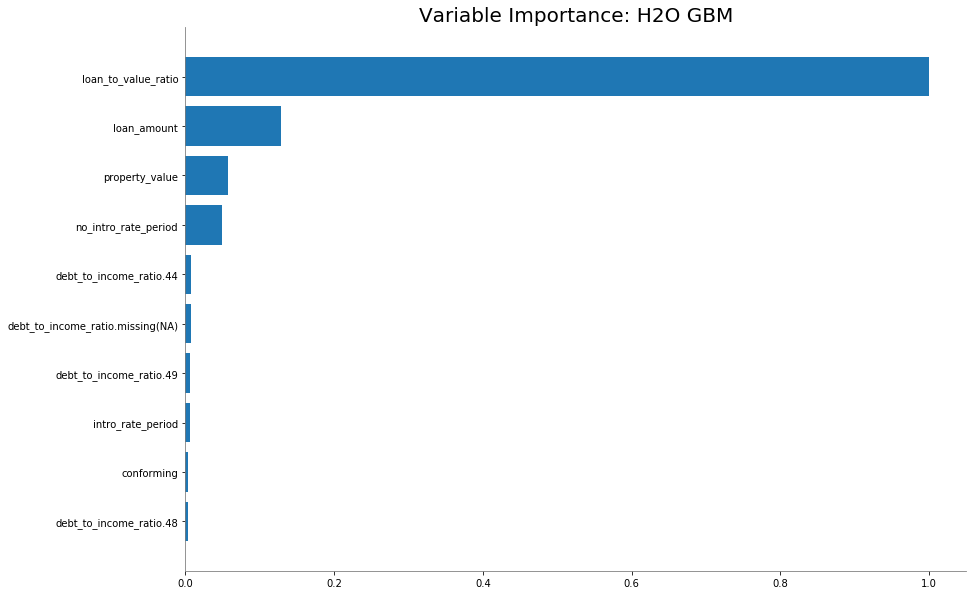

In [17]:
mgbm_default.varimp_plot()

In [18]:
# Default XGBoost
mxgb_default = H2OXGBoostEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED)
mxgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [19]:
mxgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1574453305437_7157


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07700437831775725
RMSE: 0.27749662757907034
LogLoss: 0.26229947005084747
Mean Per-Class Error: 0.2543929253100814
AUC: 0.804110979195728
pr_auc: 0.28308754952516946
Gini: 0.6082219583914561

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18662973353639245: 


,,0,1,Error,Rate
0,0,118040.0,26793.0,0.185,(26793.0/144833.0)
1,1,6101.0,9404.0,0.3935,(6101.0/15505.0)
2,Total,124141.0,36197.0,0.2052,(32894.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.186630,0.363777,199.0
1,max f2,0.093340,0.520418,264.0
2,max f0point5,0.261396,0.316003,147.0
3,max accuracy,0.708210,0.903342,11.0
4,max precision,0.916047,1.000000,0.0
5,max recall,0.002628,1.000000,397.0
6,max specificity,0.916047,1.000000,0.0
7,max absolute_mcc,0.123454,0.307625,239.0
8,max min_per_class_accuracy,0.130612,0.737691,234.0
9,max mean_per_class_accuracy,0.093340,0.745607,264.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010016,0.435875,4.732673,4.732673,0.457659,0.517859,0.457659,0.517859,0.047404,0.047404,373.267291,373.267291
1,,2,0.020026,0.364054,3.923801,4.328363,0.379439,0.393476,0.418561,0.455687,0.039278,0.086682,292.380076,332.836279
2,,3,0.030211,0.339973,3.520897,4.056151,0.340478,0.351505,0.392238,0.420565,0.035859,0.122541,252.089682,305.615141
3,,4,0.040140,0.311610,3.390722,3.891552,0.327889,0.320521,0.376321,0.395818,0.033667,0.156208,239.072159,289.155161
4,,5,0.050206,0.282451,3.126662,3.738194,0.302354,0.293428,0.361491,0.375289,0.031474,0.187681,212.666234,273.819369
5,,6,0.101635,0.241684,2.633544,3.179226,0.254669,0.262022,0.307437,0.317975,0.135440,0.323122,163.354447,217.922600
6,,7,0.150033,0.220031,2.424017,2.935610,0.234407,0.229488,0.283879,0.289431,0.117317,0.440439,142.401704,193.561021
7,,8,0.200795,0.201813,2.274294,2.768427,0.219929,0.213277,0.267712,0.270179,0.115447,0.555885,127.429436,176.842742
8,,9,0.300528,0.135175,1.752501,2.431282,0.169470,0.167763,0.235110,0.236191,0.174782,0.730668,75.250134,143.128232
9,,10,0.400042,0.077597,1.057048,2.089427,0.102219,0.101397,0.202052,0.202660,0.105192,0.835859,5.704780,108.942697




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.077460709598112
RMSE: 0.2783176415502833
LogLoss: 0.2641352924722241
Mean Per-Class Error: 0.2570519002689602
AUC: 0.8005774218054201
pr_auc: 0.27409921059758185
Gini: 0.6011548436108403

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19049908120423456: 


,,0,1,Error,Rate
0,0,118491.0,26342.0,0.1819,(26342.0/144833.0)
1,1,6269.0,9236.0,0.4043,(6269.0/15505.0)
2,Total,124760.0,35578.0,0.2034,(32611.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.190499,0.361608,201.0
1,max f2,0.103024,0.517697,266.0
2,max f0point5,0.256995,0.309455,149.0
3,max accuracy,0.949757,0.903292,0.0
4,max precision,0.795154,0.421053,6.0
5,max recall,0.000884,1.000000,399.0
6,max specificity,0.949757,0.999993,0.0
7,max absolute_mcc,0.124936,0.306012,249.0
8,max min_per_class_accuracy,0.130117,0.737891,246.0
9,max mean_per_class_accuracy,0.094281,0.742948,274.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.431482,4.319516,4.319516,0.417706,0.522114,0.417706,0.522114,0.043212,0.043212,331.951643,331.951643
1,,2,0.020001,0.365102,3.999658,4.159637,0.386775,0.393961,0.402245,0.458058,0.039987,0.083199,299.965801,315.963709
2,,3,0.030005,0.340049,3.552319,3.957156,0.343516,0.352614,0.382665,0.422902,0.035537,0.118736,255.231874,295.715556
3,,4,0.040003,0.311078,3.380356,3.813001,0.326887,0.321950,0.368725,0.397672,0.033796,0.152531,238.035612,281.300066
4,,5,0.050219,0.286387,2.866201,3.620395,0.277167,0.297993,0.350099,0.377395,0.029281,0.181812,186.620102,262.039537
5,,6,0.100020,0.243551,2.656167,3.140296,0.256857,0.263262,0.303673,0.320567,0.132280,0.314092,165.616733,214.029555
6,,7,0.150002,0.220247,2.438805,2.906553,0.235837,0.229358,0.281069,0.290175,0.121896,0.435988,143.880545,190.655302
7,,8,0.200015,0.201586,2.277378,2.749230,0.220227,0.213458,0.265856,0.270992,0.113899,0.549887,127.737830,174.922991
8,,9,0.300004,0.134489,1.769950,2.422844,0.171158,0.168868,0.234294,0.236955,0.176975,0.726862,76.995039,142.284412
9,,10,0.400286,0.077072,1.071472,2.084290,0.103613,0.101030,0.201555,0.202902,0.107449,0.834312,7.147157,108.429036




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.78605485,0.012616578,0.77093625,0.79208046,0.7746677,0.79226696,0.80032283
1,auc,0.8008067,0.0038102304,0.7959835,0.80604583,0.80069065,0.80256754,0.79874605
2,err,0.21394517,0.012616578,0.22906373,0.20791955,0.22533233,0.20773306,0.19967718
3,err_count,6860.0,391.29144,7325.0,6616.0,7221.0,6705.0,6433.0
4,f0point5,0.2893308,0.010846187,0.27897233,0.30211803,0.2804351,0.28550377,0.29962486
5,f1,0.3624184,0.00801768,0.35593072,0.3740776,0.3577337,0.35683453,0.36751547
6,f2,0.48545668,0.00921474,0.4915246,0.49103373,0.4938605,0.47567898,0.4751856
7,lift_top_group,4.298369,0.20431516,4.0987425,4.3818293,4.5990286,4.1262875,4.2859564
8,logloss,0.26414356,0.0039046633,0.26480797,0.2679079,0.26063073,0.25958595,0.26778528
9,max_per_class_error,0.37142426,0.030926405,0.34114584,0.3796674,0.33826917,0.38856015,0.40947866



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-11-26 16:37:37,44.499 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.903298
1,,2019-11-26 16:37:38,45.109 sec,1.0,0.405005,0.517472,0.790949,0.264752,3.909422,0.213175
2,,2019-11-26 16:37:38,45.476 sec,2.0,0.349888,0.422482,0.792091,0.263707,3.917860,0.213175
3,,2019-11-26 16:37:39,45.832 sec,3.0,0.318075,0.365391,0.793992,0.266584,3.936398,0.213175
4,,2019-11-26 16:37:39,46.228 sec,4.0,0.300089,0.329419,0.795630,0.267592,3.995199,0.213730
5,,2019-11-26 16:37:39,46.638 sec,5.0,0.290166,0.306312,0.796441,0.269577,4.121807,0.213081
6,,2019-11-26 16:37:40,47.059 sec,6.0,0.284772,0.291326,0.796780,0.270437,4.149538,0.209096
7,,2019-11-26 16:37:40,47.452 sec,7.0,0.281925,0.281786,0.797093,0.270874,4.183955,0.208067
8,,2019-11-26 16:37:41,47.851 sec,8.0,0.280376,0.275571,0.797488,0.270723,4.158021,0.207948
9,,2019-11-26 16:37:41,48.223 sec,9.0,0.279456,0.271449,0.797886,0.272075,4.198556,0.208004



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,24007.066406,1.000000,0.792180
1,loan_amount,3136.187500,0.130636,0.103487
2,property_value,1154.338257,0.048083,0.038091
3,no_intro_rate_period,444.588715,0.018519,0.014670
4,intro_rate_period,327.802734,0.013654,0.010817
5,income,320.280090,0.013341,0.010569
6,debt_to_income_ratio.missing(NA),181.330292,0.007553,0.005984
7,term_360,125.705978,0.005236,0.004148
8,debt_to_income_ratio.49,98.432487,0.004100,0.003248
9,debt_to_income_ratio.44,91.137421,0.003796,0.003007



See the whole table with table.as_data_frame()


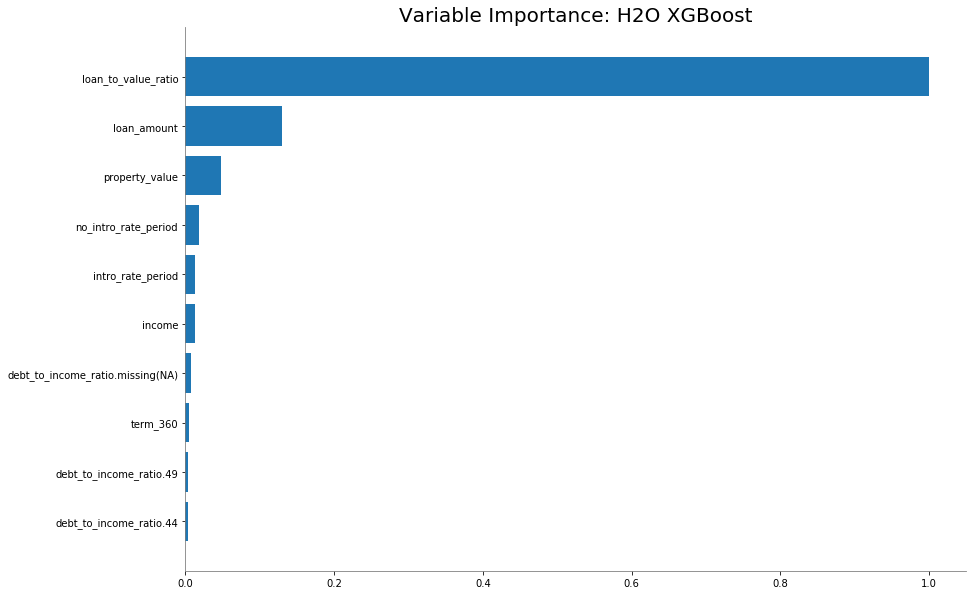

In [20]:
mxgb_default.varimp_plot()

In [21]:
# Function to get Shapley contribs
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

In [22]:
shap_values_mgbm_default, expected_value_mgbm_default = get_shapley(mgbm_default, train, X)

First 5 rows of contributions:



loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,term_360,conforming,debt_to_income_ratio.36,debt_to_income_ratio.37,debt_to_income_ratio.38,debt_to_income_ratio.39,debt_to_income_ratio.40,debt_to_income_ratio.41,debt_to_income_ratio.42,debt_to_income_ratio.43,debt_to_income_ratio.44,debt_to_income_ratio.45,debt_to_income_ratio.46,debt_to_income_ratio.47,debt_to_income_ratio.48,debt_to_income_ratio.49,debt_to_income_ratio.missing(NA),BiasTerm
0.149672,1.21846,0.0073409,0.0153256,0.145209,0.000552958,0.0176946,0.00206307,0.00299012,0.00280087,0.00256215,0.000151659,0.000180525,0.00100981,-0.00058722,-0.00271999,-0.0021585,-0.000160391,6.14197e-06,0.0479663,-0.000894849,0.000201235,0.0568875,-2.77627
-0.028763,0.168518,0.00428516,0.0151154,-0.0138766,0.000252224,0.0217169,0.00316391,0.00391788,0.00279125,0.00318366,-0.000202089,5.42237e-05,0.000206266,-0.000498866,-0.00203323,-0.00229458,0.000556543,-1.14249e-05,-0.00134136,-0.00161342,-0.000674278,-0.094854,-2.77627
0.171949,1.1166,-0.310329,-0.431366,0.215778,-0.00193938,0.0119978,0.00281047,0.00209362,0.00180397,0.00156071,-0.00216033,0.000182546,0.000386563,-0.000883473,-0.00200102,-0.00305085,-1.0283e-05,-0.000764732,-0.00162128,-0.000649061,0.000313349,0.049142,-2.77627
-0.0279263,-1.06863,0.00202472,0.0196301,-0.185567,0.000246224,0.0322245,0.00411257,0.00244096,0.00380458,0.00231905,0.000230099,1.96348e-05,0.000271092,-0.000653472,-0.00153769,-0.0013425,-0.000245373,0.000326134,-0.000788384,0.000308053,0.00724333,-0.051239,-2.77627
0.147512,1.21609,0.00712573,0.01533,0.144242,0.000343197,0.0170548,0.00206307,0.00298971,0.00279997,0.00256215,0.000151659,0.000181028,0.000970168,-0.000603803,-0.00292032,-0.00223355,-0.000134368,0.00253537,-0.00180163,-0.00121537,-0.000159826,0.055831,-2.77627


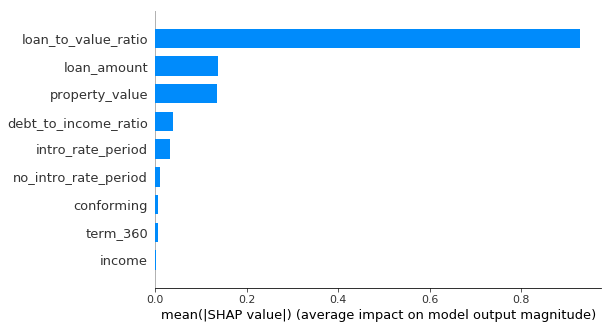

In [23]:
shap.summary_plot(shap_values_mgbm_default, X, plot_type="bar")

In [24]:
shap_values_mxgb_default, expected_value_mxgb_default = get_shapley(mxgb_default, train, X)

First 5 rows of contributions:



debt_to_income_ratio.36,debt_to_income_ratio.37,debt_to_income_ratio.38,debt_to_income_ratio.39,debt_to_income_ratio.40,debt_to_income_ratio.41,debt_to_income_ratio.42,debt_to_income_ratio.43,debt_to_income_ratio.44,debt_to_income_ratio.45,debt_to_income_ratio.46,debt_to_income_ratio.47,debt_to_income_ratio.48,debt_to_income_ratio.49,debt_to_income_ratio.missing(NA),loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,term_360,conforming,BiasTerm
0.00911196,0.00957002,0.00951057,0.00570826,0.00458102,0.00405982,-0.00138583,-0.00478976,-0.00425497,-0.00215347,-0.00248693,0.16188,-0.00447179,-0.00331441,0.0568575,0.18039,0.915657,0.00738421,0.0124856,0.0219341,0.0192126,0.00879883,0.000740686,-2.34232
0.0051276,0.00531009,0.00569699,0.003568,0.00211337,0.00257075,-0.00209248,-0.00456561,-0.00526034,-0.00114102,-0.00230295,-0.00446121,-0.00507262,-0.00432285,-0.142033,-0.105315,-0.234703,0.00317395,0.0116985,-0.0724924,-0.0484933,0.0121205,0.00106583,-2.34232
0.00517984,0.00979473,0.0133708,-0.11117,0.00595055,0.0038499,-0.00421875,-0.00370598,-0.00433355,-0.0024131,-0.00300188,-0.00595518,-0.00431826,-0.00282391,0.0360462,0.1935,0.757238,-0.379165,-0.963861,0.0816174,0.0916389,0.00548605,0.0361246,-2.34232
0.00883663,0.00608445,0.00506677,0.00354987,0.00327951,0.00258813,-0.00263353,-0.00578364,-0.00392225,0.00208961,-0.000944535,-0.0042742,-0.000830556,-0.000150296,-0.058585,-0.0708975,-1.64722,0.00213583,0.0111082,-0.0998056,-0.0235145,0.0340333,0.00107173,-2.34232
0.00938741,0.00960191,0.00952552,0.00531121,0.00481278,0.00412135,-0.00214093,-0.00539828,-0.00566298,-0.0029112,0.0638257,-0.00667806,-0.00432909,-0.0043471,0.0572365,0.173605,0.862338,0.00680349,0.0127037,0.059685,0.0149366,0.00780654,0.00107525,-2.34232


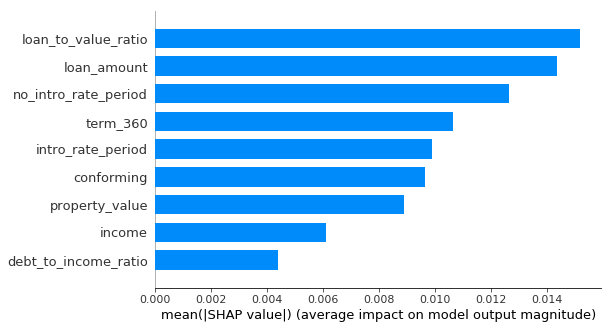

In [25]:
shap.summary_plot(shap_values_mxgb_default, X, plot_type="bar")

In [26]:
## Get the AUC on the test set for MGBM
perf_mgbm_default = mgbm_default.model_performance(test)
print(perf_mgbm_default.auc())

0.8033192917544545


In [27]:
## Get the AUC on the test set for MGBM
perf_cv_mgbm_default = mgbm_default.model_performance(xval=True)
print(perf_cv_mgbm_default.auc())

0.7971637674359789


In [28]:
## Get the AUC on the test set for MXGB
perf_mxgb_default = mxgb_default.model_performance(test)
print(perf_mxgb_default.auc())

0.8066998332524288


In [29]:
## Get the AUC on the test set for MXGB
perf_cv_mxgb_default = mxgb_default.model_performance(xval=True)
print(perf_cv_mxgb_default.auc())

0.8005774218054201


In [30]:
mgbm_lucky = H2OGradientBoostingEstimator(
  # monotonicity constraints
  monotone_constraints=mono_constraints,
    
  # more trees is better if the learning rate is small enough 
  # here, use "more than enough" trees - we have early stopping
  ntrees = 10000,                                                            

  # smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
  learn_rate = 0.01,                                                         

  # early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 

  # sample 80% of rows per tree
  sample_rate = 0.8,                                                       

  # sample 80% of columns per split
  col_sample_rate = 0.8,                                                   

  # fix a random number generator seed for reproducibility
  seed = SEED,                                                             

  # score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10)

mgbm_lucky.train(x=X, y=Y, training_frame=train, fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [31]:
mgbm_lucky

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1574453305437_7309


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,690.0,690.0,162218.0,0.0,5.0,4.934782,1.0,26.0,14.015942




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07743184616089116
RMSE: 0.2782657833095747
LogLoss: 0.26420071485421104
Mean Per-Class Error: 0.2572795306935953
AUC: 0.7999862141484112
pr_auc: 0.27351534247208603
Gini: 0.5999724282968224

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17676497988045223: 


,,0,1,Error,Rate
0,0,116827.0,28006.0,0.1934,(28006.0/144833.0)
1,1,5966.0,9539.0,0.3848,(5966.0/15505.0)
2,Total,122793.0,37545.0,0.2119,(33972.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.176765,0.359623,203.0
1,max f2,0.102482,0.517401,262.0
2,max f0point5,0.260640,0.310378,139.0
3,max accuracy,0.732631,0.903298,0.0
4,max precision,0.732631,0.500000,0.0
5,max recall,0.005725,1.000000,396.0
6,max specificity,0.732631,0.999986,0.0
7,max absolute_mcc,0.140943,0.304577,229.0
8,max min_per_class_accuracy,0.129732,0.736988,237.0
9,max mean_per_class_accuracy,0.095481,0.742720,268.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.410843,4.358199,4.358199,0.421446,0.482296,0.421446,0.482296,0.043599,0.043599,335.819867,335.819867
1,,2,0.020051,0.359155,3.723035,4.039925,0.360025,0.383224,0.390669,0.432652,0.037407,0.081006,272.303522,303.992547
2,,3,0.030068,0.328816,3.631602,3.903902,0.351183,0.344552,0.377515,0.403303,0.036375,0.117381,263.160207,290.390237
3,,4,0.040234,0.300819,3.305330,3.752659,0.319632,0.311496,0.362889,0.380106,0.033602,0.150984,230.532989,275.265866
4,,5,0.050001,0.287106,3.057412,3.616853,0.295658,0.293266,0.349757,0.363143,0.029861,0.180845,205.741171,261.685266
5,,6,0.100089,0.239008,2.626789,3.121389,0.254016,0.265518,0.301844,0.314288,0.131570,0.312415,162.678927,212.138911
6,,7,0.150245,0.216943,2.470177,2.903994,0.238871,0.226882,0.280822,0.285109,0.123896,0.436311,147.017651,190.399385
7,,8,0.200090,0.199008,2.230727,2.736275,0.215716,0.208905,0.264603,0.266126,0.111190,0.547501,123.072728,173.627530
8,,9,0.300316,0.136413,1.778635,2.416677,0.171998,0.164952,0.233697,0.232361,0.178265,0.725766,77.863508,141.667740
9,,10,0.400017,0.079791,1.080292,2.083592,0.104466,0.102113,0.201487,0.199897,0.107707,0.833473,8.029248,108.359172




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.0776129268267913
RMSE: 0.2785909668793863
LogLoss: 0.26489918007338276
Mean Per-Class Error: 0.2577420741133447
AUC: 0.798352530618541
pr_auc: 0.2695445220200297
Gini: 0.5967050612370819

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17929849199195: 


,,0,1,Error,Rate
0,0,117752.0,27081.0,0.187,(27081.0/144833.0)
1,1,6193.0,9312.0,0.3994,(6193.0/15505.0)
2,Total,123945.0,36393.0,0.2075,(33274.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.179298,0.358858,203.0
1,max f2,0.095844,0.516646,272.0
2,max f0point5,0.259972,0.305874,139.0
3,max accuracy,0.730885,0.903286,0.0
4,max precision,0.397973,0.408843,62.0
5,max recall,0.004437,1.000000,398.0
6,max specificity,0.730885,0.999979,0.0
7,max absolute_mcc,0.130833,0.303697,241.0
8,max min_per_class_accuracy,0.128227,0.736883,243.0
9,max mean_per_class_accuracy,0.095844,0.742258,272.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.415675,4.151893,4.151893,0.401496,0.483463,0.401496,0.483463,0.041535,0.041535,315.189340,315.189340
1,,2,0.020014,0.358251,3.788497,3.970139,0.366355,0.383172,0.383920,0.433302,0.037923,0.079458,278.849729,297.013873
2,,3,0.030005,0.328981,3.692310,3.877626,0.357054,0.343213,0.374974,0.403304,0.036891,0.116350,269.231044,287.762555
3,,4,0.040015,0.301946,3.060436,3.673201,0.295950,0.313611,0.355206,0.380867,0.030635,0.146985,206.043574,267.320073
4,,5,0.050032,0.286967,3.045652,3.547566,0.294521,0.294366,0.343057,0.363549,0.030506,0.177491,204.565209,254.756583
5,,6,0.100026,0.240947,2.684597,3.116243,0.259606,0.265094,0.301347,0.314340,0.134215,0.311706,168.459677,211.624272
6,,7,0.150014,0.216822,2.411407,2.881376,0.233188,0.226773,0.278635,0.285161,0.120542,0.432248,141.140672,188.137553
7,,8,0.200152,0.198479,2.271712,2.728656,0.219679,0.209025,0.263866,0.266089,0.113899,0.546146,127.171247,172.865581
8,,9,0.300004,0.135460,1.790468,2.416395,0.173142,0.164699,0.233670,0.232343,0.178781,0.724927,79.046809,141.639467
9,,10,0.399999,0.079422,1.070676,2.079981,0.103536,0.101634,0.201138,0.199667,0.107062,0.831990,7.067580,107.998069




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.78212804,0.0073883324,0.7778785,0.78277814,0.78796107,0.77197385,0.7900487
1,auc,0.7985678,0.0037458094,0.79382616,0.80352426,0.798541,0.80060166,0.79634583
2,err,0.21787193,0.0073883324,0.22212146,0.21722187,0.21203895,0.22802615,0.20995127
3,err_count,6986.8,247.38776,7103.0,6912.0,6795.0,7360.0,6764.0
4,f0point5,0.28601852,0.0081709,0.2796488,0.2967566,0.28478438,0.2772147,0.29168817
5,f1,0.35995921,0.007318303,0.35362634,0.37163636,0.35744682,0.3548387,0.3622478
6,f2,0.4856895,0.008651134,0.48082158,0.49705753,0.47989032,0.49284115,0.47783694
7,lift_top_group,4.16314,0.20159715,4.261391,4.162738,4.388257,3.843415,4.159899
8,logloss,0.2649083,0.003996079,0.26537195,0.26904458,0.2615447,0.26013848,0.26844183
9,max_per_class_error,0.36638793,0.021887574,0.36751303,0.3586445,0.3780849,0.33464825,0.39304897



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-11-26 16:40:30,2 min 14.191 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-11-26 16:40:30,2 min 14.495 sec,10.0,0.292902,0.309124,0.791145,0.256753,3.899612,0.227569
2,,2019-11-26 16:40:30,2 min 14.820 sec,20.0,0.290715,0.302359,0.791279,0.256907,3.900963,0.227781
3,,2019-11-26 16:40:30,2 min 15.171 sec,30.0,0.288948,0.297087,0.791912,0.258024,3.918314,0.234330
4,,2019-11-26 16:40:31,2 min 15.505 sec,40.0,0.287364,0.292397,0.792007,0.258017,3.954298,0.242375
5,,2019-11-26 16:40:31,2 min 15.856 sec,50.0,0.286048,0.288526,0.792177,0.258247,3.943884,0.230326
6,,2019-11-26 16:40:32,2 min 16.212 sec,60.0,0.284935,0.285278,0.792417,0.258807,3.928376,0.230407
7,,2019-11-26 16:40:32,2 min 16.612 sec,70.0,0.284084,0.282760,0.792712,0.259729,4.035847,0.229253
8,,2019-11-26 16:40:32,2 min 16.999 sec,80.0,0.283309,0.280472,0.793123,0.261020,4.181522,0.229465
9,,2019-11-26 16:40:33,2 min 17.378 sec,90.0,0.282680,0.278614,0.793338,0.261647,4.171235,0.229234



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,59516.628906,1.000000,0.760374
1,property_value,7230.620117,0.121489,0.092377
2,loan_amount,5810.938965,0.097636,0.074240
3,debt_to_income_ratio,2599.998779,0.043685,0.033217
4,no_intro_rate_period,1478.226807,0.024837,0.018886
5,intro_rate_period,1104.405640,0.018556,0.014110
6,conforming,224.852768,0.003778,0.002873
7,term_360,200.898499,0.003376,0.002567
8,income,106.232391,0.001785,0.001357


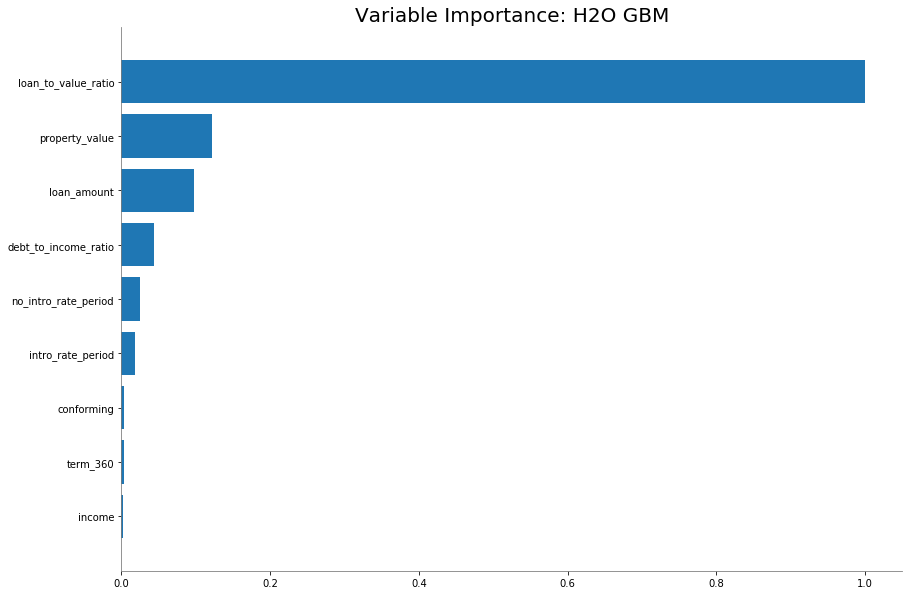

In [32]:
mgbm_lucky.varimp_plot()

In [33]:
shap_values_mgbm_lucky, expected_value_mgbm_lucky = get_shapley(mgbm_lucky, train, X)

First 5 rows of contributions:



loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,BiasTerm
0.174613,1.1049,0.0205889,0.0347353,0.188873,0.00195159,0.207933,0.0151856,0.00371838,-2.71389
-0.0166781,0.118471,0.0067754,0.0203637,-0.039952,0.000231364,-0.0949988,0.0175095,0.00242328,-2.71389
0.243728,0.96045,-0.175346,-0.728434,0.204988,0.000375473,-0.0449783,0.0130028,0.00734114,-2.71389
-0.00331808,-1.14312,0.00455011,0.0176726,-0.202808,-0.000898286,-0.0924707,0.0284902,0.00433091,-2.71389
0.181505,1.14147,0.0194718,0.0330922,0.196756,0.00103827,0.107835,0.0148527,0.00344808,-2.71389


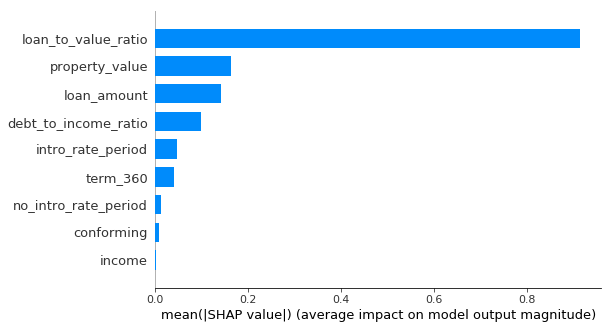

In [34]:
shap.summary_plot(shap_values_mgbm_lucky, X, plot_type="bar")

In [35]:
## Get the AUC on the test set
perf_mgbm_lucky = mgbm_lucky.model_performance(test)
print(perf_mgbm_lucky.auc())

0.8048177945625777


In [36]:
## Get the AUC on the test set
perf_cv_mgbm_lucky = mgbm_lucky.model_performance(xval=True)
print(perf_cv_mgbm_lucky.auc())

0.798352530618541


In [ ]:
#Build initial GBM Model
mgbm_grid = H2OGradientBoostingEstimator(
        # monotonicity constraints
        monotone_constraints=mono_constraints,
        # smaller learning rate is better
        # since we have learning_rate_annealing, we can afford to start with a 
        # bigger learning rate
        learn_rate=0.05,
        # learning rate annealing: learning_rate shrinks by 1% after every tree 
        # (use 1.00 to disable, but then lower the learning_rate)
        learn_rate_annealing = 0.99,
        # fix a random number generator seed for reproducibility
        seed = 1234,
        # score every 10 trees to make early stopping reproducible 
        # (it depends on the scoring interval)
        score_tree_interval = 10, 
        # early stopping once the validation AUC doesn't improve by at least 0.01% for 
        # 5 consecutive scoring events
        stopping_rounds = 5,
        stopping_metric = "AUC",
        stopping_tolerance = 1e-4)

# define random grid search parameters
hyper_parameters = {'ntrees':list(range(1, 501, 50)),
                    'max_depth':list(range(1, 21, 2)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate_per_tree':list(np.arange(0.2, 1, 0.01)),
                    'col_sample_rate_change_per_level':list(np.arange(0.9, 1.1, 0.01)),
                    'min_rows':list(np.arange(1, 2**(np.log2(train.shape[0])-1), 100)),
                    'nbins':list(range(16, 1024, 16)),
                    'nbins_cats':list(range(16, 4096, 16)),
                    'min_split_improvement':[0, 1e-8, 1e-6, 1e-4],
                    'histogram_type':['UniformAdaptive' ,'QuantilesGlobal', 'RoundRobin', 'Random']}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':250,
                   'max_runtime_secs':1200,
                   'seed':SEED}

# initialize grid search
gsearch = H2OGridSearch(mgbm_grid,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=X,
              y=Y,
              training_frame=train,
              stopping_tolerance = 1e-6,             
              seed=SEED)

In [ ]:
## by default, display the grid search results sorted by increasing logloss (since this is a classification task)
print(mgbm_grid_search)